In [1]:
from pygromos.files.topology import top
from pygromos.files.topology import ptp

import numpy as np

In [2]:
in_top1_path = "F313.top"
in_top2_path = "G078.top"
out_ptp_path = "test.ptp"

in_coord2_path = "G078_unitedatom_optimised_geometry.g96"
in_coord1_path = "F313_unitedatom_optimised_geometry.g96"

In [3]:
def generate_dual_topology_approach( eds:bool=False):
    pass

In [4]:
def generate_hybrid_topology_approach():
    pass

In [5]:
atom_ids = {}

def generate_single_topology_approach(topology:top.Top, atom_mapping:dict):


    pass

In [6]:
top1 = top.Top(in_top1_path)
top2 = top.Top(in_top2_path)


## COORD

In [7]:
from pygromos.files.coord import cnf

cmol1 = cnf.Cnf(in_coord1_path)
cmol2 = cnf.Cnf(in_coord2_path)

In [8]:
cmol2.visualize()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [9]:
cmol1.visualize()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [10]:
from rdkit import Chem

mol1 = Chem.MolFromPDBBlock(cmol1.get_pdb(rdkit_ready=True), removeHs=False)
mol2 = Chem.MolFromPDBBlock(cmol2.get_pdb(rdkit_ready=True), removeHs=False)

print(mol1, mol2)


<rdkit.Chem.rdchem.Mol object at 0x000001B42C234990> <rdkit.Chem.rdchem.Mol object at 0x000001B42C234BC0>


### Atom Matching

In [26]:
from rdkit.Chem import rdFMCS

#CompareElements
mcs = rdFMCS.FindMCS([mol1, mol2],
                     atomCompare=rdFMCS.AtomCompare.CompareElements,
                     bondCompare=rdFMCS.BondCompare.CompareOrderExact,
                    ringCompare=rdFMCS.RingCompare.StrictRingFusion)
smartsString = mcs.smartsString
print(smartsString)

##MCS Match
patt = Chem.MolFromSmarts(smartsString)  # smartsString
mol1Match = mol1.GetSubstructMatch(patt)
mol2Match = mol2.GetSubstructMatch(patt)

atom_mapping = dict(zip(mol1Match, mol2Match))
len(atom_mapping), atom_mapping

[#6]1(-[#8,#1])-[#6](-[#1,#6])-[#6](-[#1,#6])-[#6](-[#6](-[#6]-1-[#1])-[#1,#6])-[#7,#6](-[#1,#6])-[#1]


(14,
 {2: 2,
  1: 3,
  3: 1,
  4: 0,
  5: 9,
  6: 10,
  7: 8,
  11: 6,
  13: 4,
  14: 5,
  12: 7,
  8: 16,
  9: 14,
  10: 17})

### Coord Alignment

In [27]:
## Align:
from rdkit.Chem import AllChem

AllChem.AlignMol(mol1, mol2, atomMap=list(atom_mapping.items()))

atom_mapping

{2: 2,
 1: 3,
 3: 1,
 4: 0,
 5: 9,
 6: 10,
 7: 8,
 11: 6,
 13: 4,
 14: 5,
 12: 7,
 8: 16,
 9: 14,
 10: 17}

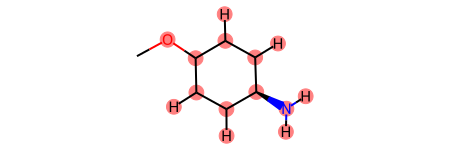

In [28]:
mol1

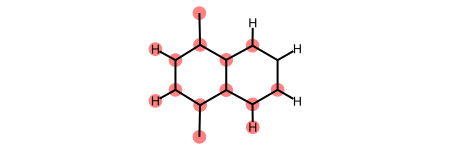

In [29]:
mol2

In [34]:
Chem.MolToPDBFile(mol1,"mol1.pdb")
Chem.MolToPDBFile(mol2,"mol2.pdb")

## COORDINATE Generation

In [30]:
conf2 = mol2.GetConformer()
for ind, pos in enumerate(conf2.GetPositions()):
    cmol2.POSITION[ind].xp= pos[0]/10
    cmol2.POSITION[ind].yp= pos[1]/10
    cmol2.POSITION[ind].zp= pos[2]/10
    
conf1 = mol1.GetConformer()
for ind, pos in enumerate(conf1.GetPositions()):
    cmol1.POSITION[ind].xp= pos[0]/10
    cmol1.POSITION[ind].yp= pos[1]/10
    cmol1.POSITION[ind].zp= pos[2]/10


In [31]:
import copy
cmol_comb = copy.deepcopy(cmol1)
for pos in cmol2.POSITION:
    if(pos.atomID in mol2Match or 
       any([np.sqrt((pos.xp-pos2.xp)**2+(pos.yp-pos2.yp)**2+(pos.zp-pos2.zp)**2) <0.9 for pos2 in cmol_comb.POSITION])):#check distance
        continue
    else:
        pos = copy.deepcopy(pos)
        pos.resID=2
        pos.atomID += len(cmol1.POSITION)
        cmol_comb.POSITION.append(pos)

#clean cmol_comb
present_atoms = []
for pos in cmol_comb.POSITION:
    pos.resID=1
    pos.resName=cmol1.POSITION[0].resName[:2]+cmol2.POSITION[0].resName[2:4]
    present_atoms.append(pos.atomID)
cmol_comb.write("fung.g96")

'fung.g96'

In [32]:
cmol_comb.POSITION

POSITION
# 	 
    1 F378  C5         1   -0.455285422    0.076238643   -0.017195234
    1 F378  O1         2   -0.330448885    0.144150737   -0.009344336
    1 F378  C4         3   -0.216276538    0.067940752   -0.002473866
    1 F378  C3         4   -0.095195130    0.138570402    0.000966375
    1 F378  H4         5   -0.097970720    0.247147426   -0.001906944
    1 F378  C2         6    0.026235650    0.070971241    0.005822188
    1 F378  H3         7    0.119103310    0.127777896    0.008033927
    1 F378  C1         8    0.030740639   -0.069696477    0.008057880
    1 F378  N1         9    0.153462954   -0.137729298    0.020284845
    1 F378  H1        10    0.151355782   -0.231711023   -0.018021879
    1 F378  H2        11    0.231911666   -0.087062181   -0.019587737
    1 F378  C7        12   -0.090832090   -0.139372834    0.004881908
    1 F378  H9        13   -0.090261575   -0.248134783    0.007160711
    1 F378  C6        14   -0.213292545   -0.071896786    0.000182986
    1 

In [33]:
cmol_comb.visualize()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

## Topology

In [19]:
com_top = top2
com_top += top1
red_com_top = copy.deepcopy(com_top)

In [20]:
#BONDS
bonds =[]
for bond in com_top.BOND:
    if(bond.IB in present_atoms and bond.JB in present_atoms):
        bonds.append(bond)
red_com_top.BOND.content = bonds
red_com_top.BOND.NBON = len(bonds)

#BondAngles
angles =[]
for angle in com_top.BONDANGLE:
    if(angle.IT in present_atoms and angle.JT in present_atoms and angle.KT in present_atoms):
        angles.append(angle)

red_com_top.BONDANGLE.content = angles
red_com_top.BONDANGLE.NTHE = len(angles)

#BondAnglesH
anglesH =[]
for angleH in com_top.BONDANGLEH:
    if(angleH.IT in present_atoms and angleH.JT in present_atoms and angleH.KT in present_atoms):
        anglesH.append(angle)

red_com_top.BONDANGLEH.content = anglesH
red_com_top.BONDANGLEH.NTHEH = len(anglesH)

#Dihedrals
dihedrals =[]
for dih in com_top.DIHEDRAL:
    if(dih.IP in present_atoms and dih.JP in present_atoms and dih.KP in present_atoms and dih.LP in present_atoms):
        dihedrals.append(dih)

red_com_top.DIHEDRAL.content = dihedrals
red_com_top.DIHEDRAL.NPHI = len(dihedrals)

#DihedralsH
dihedralsH =[]
for dihh in com_top.DIHEDRALH:
    if(dihh.IPH in present_atoms and dihh.JPH in present_atoms and dihh.KPH in present_atoms and dihh.LPH in present_atoms):
        dihedralsH.append(dihh)

red_com_top.DIHEDRALH.content = dihedralsH
red_com_top.DIHEDRALH.NPHIH = len(dihedralsH)

#Impropers
impdihedrals =[]
for imp in com_top.IMPDIHEDRAL:
    if(imp.IQ in present_atoms and imp.JQ in present_atoms and imp.KQ in present_atoms and imp.LQ in present_atoms):
        impdihedrals.append(dihh)

red_com_top.IMPDIHEDRAL.content = impdihedrals
red_com_top.IMPDIHEDRAL.NQHI = len(impdihedrals)

#ImpropersH
impdihedralsH =[]
for impH in com_top.IMPDIHEDRALH:
    if(impH.IQH in present_atoms and impH.JQH in present_atoms and impH.KQH in present_atoms and impH.LQH in present_atoms):
        impdihedralsH.append(dihh)

red_com_top.IMPDIHEDRALH.content = impdihedralsH
red_com_top.IMPDIHEDRALH.NQHIH = len(impdihedralsH)

#Mass, VDW, Charge
sol =[]
for atm in com_top.SOLUTEATOM:
    if(atm.ATNM in present_atoms):
        sol.append(atm)

red_com_top.SOLUTEATOM.content = sol 
red_com_top.SOLUTEATOM.NRP = len(sol)

"""
#crossDIHEDRAL
crds =[]
for crd in com_top.CROSSDIHEDRAL:
    print(vars(crd))
    if(crd.ATNM in present_atoms):
        crds.append(atm)

red_com_top.CROSSDIHEDRAL.content = crds 

#crossDIHEDRALH
crdsH =[]
for crdH in com_top.CROSSDIHEDRALH:
    print(vars(crdH))
    if(crdH.ATNM in present_atoms):
        crdsH.append(atm)

red_com_top.CROSSDIHEDRALH.content = crdsH
"""

##resname meshing
molA_Name = com_top.RESNAME.content[1][0]
molB_Name = com_top.RESNAME.content[2][0]

red_com_top.RESNAME.content = [['1'], [molA_Name[:2]+molB_Name[:2]]]


pass

### Build PTP

In [21]:
ptp_file = ptp.Ptp()

In [22]:
from pygromos.files.blocks.topology_blocks import PERTPROPERDIH, atom_lam_pertubation_state_dihedral

In [23]:
pertproperdih =PERTPROPERDIH()

In [24]:
for 
pertproperdih.content.append()

SyntaxError: invalid syntax (Temp/ipykernel_7584/1245646628.py, line 1)